In [0]:
# Por si alguien corre en python2
from __future__ import division

# Preparamos todo para correr
import numpy as np
from math import *
from matplotlib import pylab as plt

from tensorflow import keras
%matplotlib inline
%load_ext tensorboard

## Mixture Density Networks (MDN)
<a id='mixtures'></a>

Cuando estudiamos regresión lineal, vimos que el error cuadrático aparecía naturalmente al suponer que la distribución condicional de los labels era normal:

$$
p(t|x, \mathbf{w}, \beta) = \mathcal{N}(t|y(x,\mathbf{w}), \beta^{-1})\;\;.
$$

En ese caso, teníamos que el logaritmo de la versosimilitud de una serie de mediciones, $\mathbf{X} = \{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$, con labels / outputs, $\mathbf{t} = \{t_1, \ldots, t_N\}$ era:

$$
\begin{array}
\ln p(\mathbf{t}|\mathbf{w}, \beta) &=& \sum_{n=1}^N \ln\mathcal{N}(t_n|y(\mathbf{x},\mathbf{w}), \beta^{-1})\\
&=& \frac{N}{2}\ln\beta - \frac{N}{2}\ln(2\pi) - \beta E_D(\mathbf{w})\;\;,
\end{array}
$$
donde 
$$
E_D(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N\left\{t_n - \mathbf{w}^T\phi(\mathbf{x}_n)\right\}^2 \;\;.
$$

En el marco de los modelos de redes neuronales, las funciones de base $\phi$ se parametrizan para darle mayor flexibilidad al modelo, como estuvimos viendo estas semanas. 

Muy bien, veamos entonces que pueden hacer las redes neuronales frente a un problema sencillo de regresión, con un output y un input.

Seguimos de cerca a Bishop

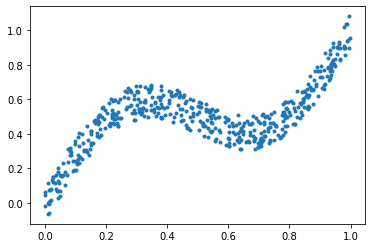

In [267]:
# Fix seed
np.random.seed(20200616)

# Create dataset
x = np.random.rand(600).reshape(-1, 1)
t = x + 0.3 * np.sin(2 * np.pi * x)
noise = (np.random.rand(x.shape[0]) * 0.2 - 0.1).reshape(-1, 1)

t += noise
# Separemos en train, test, y validation
X_train, X_validation, X_test = x[:500], x[500: 550], x[550:]
t_train, t_validation, t_test = t[:500], t[500: 550], t[550:]

# Veamos los datos
plt.plot(X_train, t_train, '.')

In [0]:
#
from tensorflow import keras

# Build simple DNN
modelo = keras.Sequential()

# Agreguemos dos capas ocultas de 10 y 8 neuronas cada una
# ...

# Agregemos una capa de output que sirva para este problema
# ...


keras.utils.plot_model(modelo, show_shapes=True)

In [0]:
# Compilemos el modelo. 
# En este punto se elije la función de périda y el optimizador.
# ¿Qué función de pérdida deberíamos usar?
modelo.compile(loss=..., optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [0]:
# Es hora de entrenar el modelo. Corramos 500 épocas, y vayamos mirando también
# la validación.

# Usemos EarlyStopping para no pasar tiempo de más entrenando
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping
early = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=50, verbose=0, 
                      mode='auto')

history = modelo.fit(X_train, t_train, epochs=500, 
                     validation_data=(X_validation, t_validation),
                     callbacks=[early,])

In [0]:
# Veamos el resultado del ajuste
import pandas as pd

df = pd.DataFrame(history.history)
df.plot()

In [0]:
# Veamos los datos
plt.plot(X_train, t_train, '.')

# Graficamos la predicción del modelo 
xx = np.linspace(0, 1, 1000)
plt.plot(xx, modelo.predict(xx), '-r')

Vemos que el modelo funciona bastante bien (después de tweakearlo un poco).

Ahora veamos qué pasa si invertimos el rol de las variables, de manera que los datos que queremos ajustar son diferentes.

In [0]:
# Veamos los datos
plt.plot(t_train, X_train, '.')

In [0]:
# Escribamos un modelo similar al anterior (¿podemos usar el mismo modelo?)
# ...

In [0]:
# Compilemos, ajustemos, miremos el resultado y grafiquemos la predicción.
# ¿Qué pasó?



---




Por más que intentemos, la red no va a poder ajustar los datos. 

El uso del error cuadrático implica, como vimos arriba que la distribución condicionada de las variables target $p(t | x)$ es una normal. Sin embargo, para valores como $x=0.6$ la distribución es bien multimodal, y por lo tanto no puede ser representada por una normal.

Text(0.5, 0, 'nuevo X')

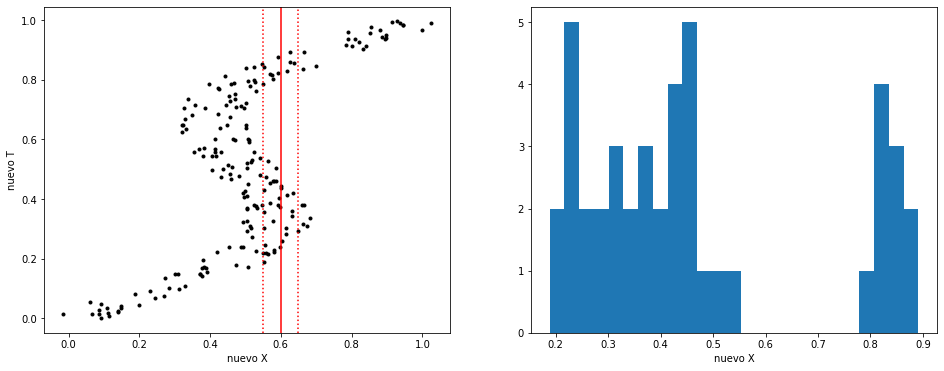

In [0]:
# Veamos un entorno de x = 0.6
epsilon = 0.05
cond = np.abs(t_train - 0.6) < epsilon

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.plot(t_train, X_train, '.k')
ax.axvline(0.6, color='r', ls='-')
for sign in (-1, 1):
    ax.axvline(0.6 + sign * epsilon, color='r', ls=':')
ax2.hist(X_train[cond], 25)

ax.set_xlabel('nuevo X')
ax.set_ylabel('nuevo T')
ax2.set_xlabel('nuevo X')


Claramente, no podremos ajustar esto con una normal. ¿Alguna idea?

...

...

...

¡Sí! ¡Mixturas de Gaussianas! El favorito de todxs.

Repasemos...

***
### Presentación del modelo

Este ejemplo muestra una de las limitaciones de un modelo normal: solo puede captar distribuciones con un único modo. Una forma de sobreponerse a este problema es usar un modelo que consista en una superposición de $K$ distribuciones normales.

$$
p(\mathbf{x}) = \sum_{k=1}^K \pi_k{\mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}\;\;,
$$
donde cada densidad $\mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ se conoce como una *componente* de la mixtura, y tiene su propio valor medio y matriz de covarianza. Los $\pi_k$ son los *coeficientes* de mezcla.

__Los coeficientes como probabilidades__

Integrando a ambos lados de la igualdad sobre todos los valore de $\mathbf{x}$ y viendo que tanto $p(\mathbf{x})$ como las componentes normales son funciones de distribución de probabilidad, llegamos a que

$$
\sum_{k=1}^K \pi_k = 1\;\;.
$$

Además, como $p(\mathbf{x})$ tienen que ser positiva, encontramos que una forma de garantizar eso de manera general es definir que los coeficientes sean positivos. Por lo tanto, $0 \leq \pi_k \leq 1$, y los coeficientes satisfacen los requerimientos para ser probabilidades.

Podemos, entonces, asignar una función de distribución de masa, $p(k)$, que describe la probabilidad (prior) de que se elija la compoenente $k$, y $p(k) = \pi_k$. Entonces, distribución sobre $\mathbf{x}$ queda:

$$
p(\mathbf{x}) = \sum_{k=1}^K p(\mathbf{x}, k) = \sum_{k=1}^K p(k) p(\mathbf{x} | k)\;\;,
$$

donde la probabilidad condicionada $p(\mathbf{x} | k) = \mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$.

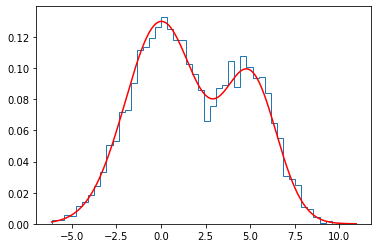

In [0]:
import scipy.stats as st

# Supongamos una distribución unidimensional de dos modos, con los siguientes parámetros
mu1 = [0.0,]
sigma1 = [2.0,]
mu2 = [5.0,]
sigma2 = [1.5,]

# Generemos las dos distris
n1 = st.norm(mu1, sigma1)
n2 = st.norm(mu2, sigma2)

# Ahora pensemos que tenemos una distribución prior p(k) con las siguientes elementos
p1 = 0.65
p2 = 0.35

# Veamos como podemos generar, fácilmente, muestras de la mixtura:
# p1 * N1 + p2 * N2
# Primero muestreo p(k)
N = 5000
k = np.where(np.random.rand(N) < p1, 1, 2)

# Y ahora lo combino con las mixturas

# Modo 1 (estricto)
# x1 = n1.rvs(sum(k==1), 1)
# x2 = n2.rvs(sum(k==2), 1)

# x = np.hstack([x1, x2])

# Modo 2 (generando de más)
x1 = n1.rvs(N, 1)
x2 = n2.rvs(N, 1)

x = np.where(k==1, x1, x2).reshape((-1, 1))

h = plt.hist(x, 50, histtype='step', density=True)

# Combinemos esto con la pdf del modelo
xx = np.linspace(x.min(), x.max(), 400)
plt.plot(xx, p1 * n1.pdf(xx) + p2 * n2.pdf(xx), 'r-')

__Responsabilidades__

Un rol crucial lo van a jugar las posteriores de la probabilidad de cada modo $p(k \:|\: \mathbf{x})$, que se conocen como *responsabilidades* (¡cuánta seriedad!)

$$
\gamma_k(\mathbf{x}) \equiv p(k \:|\: \mathbf{x})\;\;.
$$

Como es de esperar, podemos calcular la punta que tienen las responsabilidades a partir del teorema de Bayes:

$$
\begin{eqnarray}
\gamma_k(\mathbf{x}) &=& \frac{p(k) p(\mathbf{x}\:|\:k)}{\sum_i p(i) p(\mathbf{x}\:|\:i)}\\
   &=&\frac{\pi_k{\mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}}{\sum_i{\pi_i{\mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_i, \boldsymbol{\Sigma}_i)}}}\;\;,
\end{eqnarray}
$$
donde usamos la definición de arriba
$$
p(\mathbf{x}) = \sum_{k=1}^K \pi_k{\mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}\;\;.
$$

__Verosimilitud__ (o Donde arrancan los líos)

Naturalmente, necesitaremos poder escribir la verosimilitud para un modelo de este tipo. Como vimos arriba, el problema con las exponenciales de la normal, es que muchas veces generan problemas numéricos.

Vamos entonces a escribir el logaritmo de la verosimilitud, como ya hicimos un montón de veces.

$$
\ln p(\mathbf{X} \:|\: \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi}) = \sum_{n=1}^N \ln \left\{\sum_{k=1}^K \pi_k{\mathcal{N}(\mathbf{x}_n \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}\right\}\;\;,
$$
donde estamos usando esta notación: $\boldsymbol{\mu} \equiv \left\{\boldsymbol{\mu}_1, \ldots, \boldsymbol{\mu}_K\right\}$, y lo mismo para $\boldsymbol{\Sigma}$ y para $\boldsymbol{\pi}$. Y como siempre $\mathbf{X} = \left\{\mathbf{x}_1, \ldots, \mathbf{x}_N\right\}$.

Vemos que el logaritmo actúa sobre la sumatoria y no sobre cada normal de manera individual. Esto hace que sea complicado obtener una forma cerrada para los parámetros que maximizan la verosimilitud. Tenemos que usar un procedimiento iterativo, conocido como el algoritmo de maximización de la expectación, o *expectation maximisation* (EM).


__Un paso más__

En el contexto de las redes neuronales, vamos a dar un paso más y permitir a los parámetros de cada componente que cambien con la variable del input, $\mathbf{x}$.

Así, tanto los coeficientes de mezcla, como los vectores $\boldsymbol{\mu}$, como la varianza de cada normal (que consideraremos isotrópica para cada $\mathbf{x}$, se convierten en funciones del input.

El modelo pasa de ser una normal con covarianza general:

$$
p(t|\mathbf{x}) = \mathcal{N}(t|y(\mathbf{x},\mathbf{w}), \beta^{-1})\;\;.
$$

a ser una mixtura de normales isotrópicas (si bien la extensión a covarianzas generales es posible):

$$
p(t | \mathbf{x}) = \sum_{k=1}^K \pi_k(\mathbf{x}){\mathcal{N}(t \:|\: \boldsymbol{\mu}_k(\mathbf{x}), \sigma^2_k(\mathbf{x}))}\;\;.
$$

Esta formulación es un ejemplo de un modelo heterocedastico (wow!); es decir, que la varianza cambia con la variable $x$. 

### Implementación

Todo esto es muy lindo, pero ¿cómo se implementa en un modelo de redes neuronales?

La idea es generar una red cuyos outputs sean las parámetros del modelo. Para eso, tenemos que usar la API funcional de `Keras`

(VER DIAPOS!)

**Nota**: Nos inspiramos en el código de https://github.com/oborchers/Medium_Repo

[](https://drive.google.com/uc?export=view&id=1-a9oAqcGYPgBoSkg9yTXfzxsu5MBjdA5)


In [0]:
from tensorflow.keras.layers import Input, Dense, Concatenate

neurons = 500     # Neurons of the DNN hidden layers
components = 3    # Number of components in the mixture
no_parameters = 3 # Paramters of the mixture (pi, mu, sigma)

input_ = Input(shape=(t_train.shape[1],))

# Escribir una o dos capas ocultas
h1 = ...
h2 = ...

# Ahora escribir una capa para cada una de las variables del problema
# Coeficientes de mezcla (que tienen que sumar 1)
# Valores medios
# Anchos de la distribución (que tiene que ser positivos)
mixcoeff =  
means = 
sigmas = 

# Concatenemos las tres capas para dar la capa de salida
pvector = Concatenate(name="output")([mixcoeff, means, sigmas])

# Y finalmente, generemos el modelo de Keras con todo esto
modelMDN = keras.Model(inputs=[input_], outputs=[pvector])

In [0]:
# Si quisieramos, podemos hacer un subclase de los modelos de Keras
class MDN(keras.Model):

    def __init__(self, neurons=100, components = 2):
        super(MDN, self).__init__(name="MDN")
        self.neurons = neurons
        self.components = components
        
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        
        self.mixcoeff = Dense(components, activation="softmax", name="mix")
        self.means = Dense(components, name="means")
        self.sigmas = Dense(components, activation="exponential", name="sigmas")
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        
        mix_v = self.mixcoeff(x)
        mean_v = self.means(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v, mu_v, sigma_v])

¡Bien! Ya tenemos el modelo. Pero eso es solo una parte del problema.

¿Qué más falta?

---

In [0]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1)*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    pi, mu, sigma = slice_parameter_vectors(parameter_vector)  # Unpack parameter vectors
    
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=pi),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    
    log_likelihood = gm.log_prob(tf.transpose(y))                 # Evaluate log-probability of y
    
    return -tf.reduce_mean(log_likelihood, axis=-1)

### Compilamos y ajustamos

Ahora podemos compilar el código usando esa función de pérdida.

In [0]:
modelMDN.compile(loss=gnll_loss, optimizer=keras.optimizers.Adam(lr=0.002))
modelMDN.summary()

In [0]:
keras.utils.plot_model(modelMDN)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping
mon = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=50, verbose=0, 
                    mode='auto')

In [0]:
# Ajustemos el modelo. Volvemos a usar early stopping

historyNEW = modelMDN.fit(t_train, X_train, epochs=1000, 
                          validation_data=(t_validation, X_validation), 
                          verbose=True, batch_size=16, callbacks=[mon,])

In [0]:
pd.DataFrame(historyNEW.history).plot()

In [0]:
# Veamos los parámetros del resultado

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

# En el primer subplot ponemos los datos.
ax.plot(t_train, X_train, '.k')
ax.set_xlabel('nuevo X')
ax.set_ylabel('nuevo T')

# Ahora calculamos la predicción.
# En este caso, no tenemos una predicción directa de los datos,
# sino los parámetros de la mixtura
xx = np.arange(0, 1.001, 0.001)
pars = modelMDN.predict(xx)
pi, mu, sigma = slice_parameter_vectors(pars)

# Podemos calcular el valor medio de la función y ponerla con los datos
tmean = np.sum(pi * mu, axis=1)
ax.plot(xx, tmean, ',')
# ¿Sorprende el resultado?

ax2.plot(xx, pi)
ax2.set_title('Mixing coefficient')
ax3.plot(xx, mu)
ax3.set_title('Valor medio')
ax4.plot(xx, sigma)
ax4.set_title('Varianza')

In [0]:
# Ahora la posta. 
# Calculemos la pdf de la distribución condicional, para una serie de valores
# de X.
import scipy.stats as st

# Primero construyo una grilla de valores
# uso xx para ambos en este caso porque los valores están todos en [0, 1].
x, y = np.meshgrid(xx, xx)

# Calcula distribución para cada componente
a = np.array([pi[:, i] * st.norm.pdf(y, loc=mu[:, i], scale=sigma[:, i]) for 
              i in range(pi.shape[1])])

# Sumo sobre todas las componentes
pdf = np.sum(a, axis=0)

In [0]:
# La hora de la verdad.
xont = plt.contourf(x, y, pdf, 30, cmap='jet')
xont = plt.contour(x, y, pdf, 15, colors=['w',], alpha=0.7)
plt.colorbar(xont)
# plt.plot(t_train, X_train, '.w', mfc='None', alpha=0.4)

In [0]:
# Quedó bueno. Salvémoslo.
modelMDN.save('MDN_ok.h')

In [0]:
import matplotlib.pyplot as plt
# Usemos el resultado de arriba para plotear la función condicionada para algunos
# valores de x
xs = [0.2, 0.5, 0.7]

fig = plt.figure(figsize=(16,9))

for i, xi in enumerate(xs):
  ax = fig.add_subplot(1, len(xs), i+1)
  ax.plot(xx, pdf[xx==xi, :])
  ax.set_title('p(t | x={}'.format(xi))
